<a href="https://colab.research.google.com/github/NielsRogge/Transformers-Tutorials/blob/master/DETR/Fine_tuning_DetrForObjectDetection_on_custom_dataset_(balloon).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Fine-tuning DETR on a custom dataset for object detection

In this notebook, we are going to fine-tune [DETR](https://huggingface.co/docs/transformers/model_doc/detr) (end-to-end object detection with Transformers) on a custom object detection dataset. The goal for the model is to detect balloons in pictures.

* Original DETR paper: https://arxiv.org/abs/2005.12872
* Original DETR repo: https://github.com/facebookresearch/detr

### Note regarding GPU memory

`DetrImageProcessor` by default resizes each image to have a `min_size` of 800 pixels and a `max_size` of 1333 pixels (as these are the default values that DETR uses at *inference* time). Note that this can stress-test the memory of your GPU when *training* the model, as the images are flattened after sent through the convolutional backbone. The sequence length that is sent through the Transformer is typically of length (height*width/32^2). So if you consider an image of size (900, 900) for example, the sequence length is 900^2/32^2 = 791, which is larger than what NLP models like BERT use (512). It's advised to use a batch size of 2 on a single GPU. You can of course also initialize `DetrImageProcessor` with a smaller `size` and/or `max_size` to use bigger batches. 


### Note regarding data augmentation

DETR actually uses several image augmentations during training. One of them is **scale augmentation**: they set the `min_size` randomly to be one of [480, 512, 544, 576, 608, 640, 672, 704, 736, 768, 800] as can be seen [here](https://github.com/facebookresearch/detr/blob/a54b77800eb8e64e3ad0d8237789fcbf2f8350c5/datasets/coco.py#L122). However, we are not going to add any of the augmentations that are used in the original implementation during training. It works fine without them.

### Training framework

We're going to fine-tune the model using [PyTorch Lightning](https://lightning.ai/pages/open-source/), but of course you could also train the model using native PyTorch, the 🤗 [Trainer](https://huggingface.co/docs/transformers/main_classes/trainer) class, 🤗 [Accelerate](https://huggingface.co/docs/accelerate/index), or any other framework you prefer.

Also big thanks to the creator of [this notebook](https://github.com/woctezuma/finetune-detr/blob/master/finetune_detr.ipynb), which helped me a lot in understanding how to fine-tune DETR on a custom dataset.


## Create PyTorch dataset + dataloaders

The standard way in PyTorch to train a model is by creating datasets and a corresponding dataloaders. See [this guide](https://pytorch.org/tutorials/beginner/basics/data_tutorial.html) if you're not familiar with them.

Here we define a regular PyTorch dataset. Each item of the dataset is an image and corresponding annotations. Torchvision already provides a `CocoDetection` dataset, which we can use. We only add an image processor (`DetrImageProcessor`) to resize + normalize the images, and to turn the annotations (which are in COCO format) in the format that DETR expects. It will also resize the annotations accordingly.

In [9]:
import torchvision
import os

class CocoDetection(torchvision.datasets.CocoDetection):
    def __init__(self, img_folder, processor, train=True):
        ann_file = os.path.join(img_folder, "_annotations.coco.json" if train else "_annotations.coco.json")
        super(CocoDetection, self).__init__(img_folder, ann_file)
        self.processor = processor

    def __getitem__(self, idx):
        # read in PIL image and target in COCO format
        # feel free to add data augmentation here before passing them to the next step
        img, target = super(CocoDetection, self).__getitem__(idx)
        
        # preprocess image and target (converting target to DETR format, resizing + normalization of both image and target)
        image_id = self.ids[idx]
        target = {'image_id': image_id, 'annotations': target}
        encoding = self.processor(images=img, annotations=target, return_tensors="pt")
        pixel_values = encoding["pixel_values"].squeeze() # remove batch dimension
        target = encoding["labels"][0] # remove batch dimension

        return pixel_values, target

Based on the class defined above, we create training and validation datasets.

In [44]:
from transformers import DetrImageProcessor

processor = DetrImageProcessor.from_pretrained("facebook/detr-resnet-50")

# train_dataset = CocoDetection(img_folder='./balloon/train', processor=processor)
train_dataset = CocoDetection(img_folder='./InBreast_Coco/fold_1/train/', processor=processor)
val_dataset = CocoDetection(img_folder='./InBreast_Coco/fold_1/valid/', processor=processor, train=False)
# val_dataset = CocoDetection(img_folder='./balloon/val', processor=processor, train=False)

loading annotations into memory...
Done (t=0.02s)
creating index...
index created!
loading annotations into memory...
Done (t=0.02s)
creating index...
index created!


As you can see, this dataset is tiny:

In [45]:
print("Number of training examples:", len(train_dataset))
print("Number of validation examples:", len(val_dataset))

Number of training examples: 85
Number of validation examples: 10


Let's verify an example by visualizing it. We can access the COCO API of the dataset by typing `train_dataset.coco`. 

Image n°4


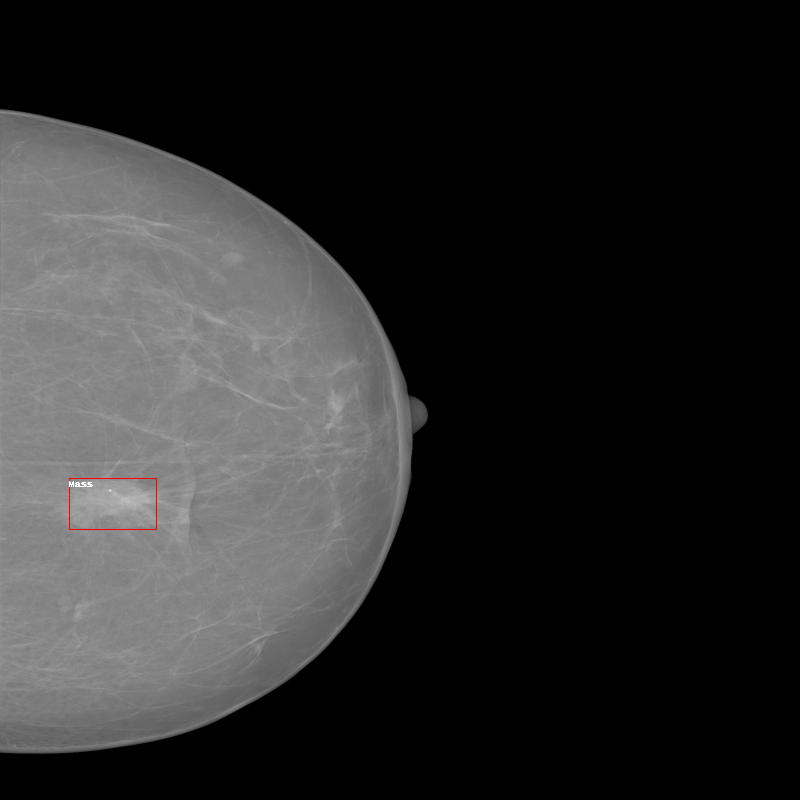

In [48]:
import numpy as np
import os
from PIL import Image, ImageDraw

# based on https://github.com/woctezuma/finetune-detr/blob/master/finetune_detr.ipynb
image_ids = train_dataset.coco.getImgIds()
# let's pick a random image
image_id = image_ids[np.random.randint(0, len(image_ids))]
print('Image n°{}'.format(image_id))
image = train_dataset.coco.loadImgs(image_id)[0]
image = Image.open(os.path.join('./InBreast_Coco/fold_1/train', image['file_name']))

annotations = train_dataset.coco.imgToAnns[image_id]
draw = ImageDraw.Draw(image, "RGBA")

cats = train_dataset.coco.cats
id2label = {k: v['name'] for k,v in cats.items()}

for annotation in annotations:
  box = annotation['bbox']
  class_idx = annotation['category_id']
  x,y,w,h = tuple(box)
  draw.rectangle((x,y,x+w,y+h), outline='red', width=1)
  draw.text((x, y), id2label[class_idx], fill='white')

image

Next, let's create corresponding PyTorch dataloaders, which allow us to get batches of data. We define a custom `collate_fn` to batch images together. As DETR resizes images to have a min size of 800 and a max size of 1333, images can have different sizes. We pad images (`pixel_values`) to the largest image in a batch, and create a corresponding `pixel_mask` to indicate which pixels are real (1)/which are padding (0).  

In [49]:
from torch.utils.data import DataLoader

def collate_fn(batch):
  pixel_values = [item[0] for item in batch]
  encoding = processor.pad(pixel_values, return_tensors="pt")
  labels = [item[1] for item in batch]
  batch = {}
  batch['pixel_values'] = encoding['pixel_values']
  batch['pixel_mask'] = encoding['pixel_mask']
  batch['labels'] = labels
  return batch

train_dataloader = DataLoader(train_dataset, collate_fn=collate_fn, batch_size=4, shuffle=True)
val_dataloader = DataLoader(val_dataset, collate_fn=collate_fn, batch_size=2)
batch = next(iter(train_dataloader))

Let's verify the keys of a single batch:

In [50]:
batch.keys()

dict_keys(['pixel_values', 'pixel_mask', 'labels'])

Let's verify the shape of the `pixel_values`, and check the `target`::

In [51]:
pixel_values, target = train_dataset[0]

In [52]:
pixel_values.shape

torch.Size([3, 800, 800])

In [53]:
print(target)

{'size': tensor([800, 800]), 'image_id': tensor([0]), 'class_labels': tensor([0]), 'boxes': tensor([[0.9569, 0.3262, 0.0862, 0.0375]]), 'area': tensor([2070.]), 'iscrowd': tensor([0]), 'orig_size': tensor([800, 800])}


## Train the model using PyTorch Lightning

Here we define a `LightningModule`, which is an `nn.Module` with some extra functionality.

For more information regarding PyTorch Lightning, I recommend the [docs](https://pytorch-lightning.readthedocs.io/en/latest/?_ga=2.35105442.2002381006.1623231889-1738348008.1615553774) as well as the [tutorial notebooks](https://github.com/PyTorchLightning/lightning-tutorials/tree/aeae8085b48339e9bd9ab61d81cc0dc8b0d48f9c/.notebooks/starters). 

You can of course just train the model in native PyTorch as an alternative.

In [54]:
import pytorch_lightning as pl
from transformers import DetrConfig, DetrForObjectDetection
import torch

class Detr(pl.LightningModule):
     def __init__(self, lr, lr_backbone, weight_decay):
         super().__init__()
         # replace COCO classification head with custom head
         # we specify the "no_timm" variant here to not rely on the timm library
         # for the convolutional backbone
         self.model = DetrForObjectDetection.from_pretrained("facebook/detr-resnet-50",
                                                             revision="no_timm", 
                                                             num_labels=len(id2label),
                                                             ignore_mismatched_sizes=True)
         # see https://github.com/PyTorchLightning/pytorch-lightning/pull/1896
         self.lr = lr
         self.lr_backbone = lr_backbone
         self.weight_decay = weight_decay

     def forward(self, pixel_values, pixel_mask):
       outputs = self.model(pixel_values=pixel_values, pixel_mask=pixel_mask)

       return outputs
     
     def common_step(self, batch, batch_idx):
       pixel_values = batch["pixel_values"]
       pixel_mask = batch["pixel_mask"]
       labels = [{k: v.to(self.device) for k, v in t.items()} for t in batch["labels"]]

       outputs = self.model(pixel_values=pixel_values, pixel_mask=pixel_mask, labels=labels)

       loss = outputs.loss
       loss_dict = outputs.loss_dict

       return loss, loss_dict

     def training_step(self, batch, batch_idx):
        loss, loss_dict = self.common_step(batch, batch_idx)     
        # logs metrics for each training_step,
        # and the average across the epoch
        self.log("training_loss", loss)
        for k,v in loss_dict.items():
          self.log("train_" + k, v.item())

        return loss

     def validation_step(self, batch, batch_idx):
        loss, loss_dict = self.common_step(batch, batch_idx)     
        self.log("validation_loss", loss)
        for k,v in loss_dict.items():
          self.log("validation_" + k, v.item())

        return loss

     def configure_optimizers(self):
        param_dicts = [
              {"params": [p for n, p in self.named_parameters() if "backbone" not in n and p.requires_grad]},
              {
                  "params": [p for n, p in self.named_parameters() if "backbone" in n and p.requires_grad],
                  "lr": self.lr_backbone,
              },
        ]
        optimizer = torch.optim.AdamW(param_dicts, lr=self.lr,
                                  weight_decay=self.weight_decay)
        
        return optimizer

     def train_dataloader(self):
        return train_dataloader

     def val_dataloader(self):
        return val_dataloader

Here we define the model, and verify the outputs.

In [55]:
model = Detr(lr=1e-4, lr_backbone=1e-5, weight_decay=1e-4)

outputs = model(pixel_values=batch['pixel_values'], pixel_mask=batch['pixel_mask'])

Some weights of DetrForObjectDetection were not initialized from the model checkpoint at facebook/detr-resnet-50 and are newly initialized because the shapes did not match:
- class_labels_classifier.weight: found shape torch.Size([92, 256]) in the checkpoint and torch.Size([2, 256]) in the model instantiated
- class_labels_classifier.bias: found shape torch.Size([92]) in the checkpoint and torch.Size([2]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


The logits are of shape `(batch_size, num_queries, number of classes + 1)`. We model internally adds an additional "no object class", which explains why we have one additional output for the class dimension. 

In [56]:
outputs.logits.shape

torch.Size([4, 100, 2])

Next, let's train! We train for a maximum of 300 training steps, and also use gradient clipping. You can refresh Tensorboard above to check the various losses.

In [57]:
from pytorch_lightning import Trainer

trainer = Trainer(max_steps=3, gradient_clip_val=0.1)
trainer.fit(model)

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name  | Type                   | Params
-------------------------------------------------
0 | model | DetrForObjectDetection | 41.5 M
-------------------------------------------------
18.0 M    Trainable params
23.5 M    Non-trainable params
41.5 M    Total params
166.007   Total estimated model params size (MB)


Sanity Checking: 0it [00:00, ?it/s]

c:\ProgramData\miniconda3\envs\detr-env\Lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:442: PossibleUserWarning: The dataloader, val_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(
c:\ProgramData\miniconda3\envs\detr-env\Lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:442: PossibleUserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(
c:\ProgramData\miniconda3\envs\detr-env\Lib\site-packages\pytorch_lightning\loops\fit_loop.py:281: PossibleUserWarning: The number of training batches (22) is smaller than the logging inte

Training: 0it [00:00, ?it/s]

`Trainer.fit` stopped: `max_steps=3` reached.


## Evaluate the model

Finally, we evaluate the model on the validation set. For this we make use of the `CocoEvaluator` class available in a [tiny PyPi package](https://github.com/NielsRogge/coco-eval) I made. This class is entirely based on the original evaluator class used by the DETR authors.

To run the evaluation, we must make sure that the outputs of the model are in the format that the metric expects. For that we need to turn the boxes which are in (x1, y1, x2, y2) format into (x, y, width, height), and turn the predictions into a list of dictionaries:

In [58]:
def convert_to_xywh(boxes):
    xmin, ymin, xmax, ymax = boxes.unbind(1)
    return torch.stack((xmin, ymin, xmax - xmin, ymax - ymin), dim=1)

def prepare_for_coco_detection(predictions):
    coco_results = []
    for original_id, prediction in predictions.items():
        if len(prediction) == 0:
            continue

        boxes = prediction["boxes"]
        boxes = convert_to_xywh(boxes).tolist()
        scores = prediction["scores"].tolist()
        labels = prediction["labels"].tolist()

        coco_results.extend(
            [
                {
                    "image_id": original_id,
                    "category_id": labels[k],
                    "bbox": box,
                    "score": scores[k],
                }
                for k, box in enumerate(boxes)
            ]
        )
    return coco_results

 Let's run the evaluation:

In [59]:
device = 'cpu'

In [62]:
from coco_eval import CocoEvaluator
from tqdm.notebook import tqdm

import numpy as np

# initialize evaluator with ground truth (gt)
evaluator = CocoEvaluator(coco_gt=val_dataset.coco, iou_types=["bbox"])

print("Running evaluation...")
for idx, batch in enumerate(tqdm(val_dataloader)):
    # get the inputs
    pixel_values = batch["pixel_values"].to(device)
    pixel_mask = batch["pixel_mask"].to(device)
    labels = [{k: v.to(device) for k, v in t.items()} for t in batch["labels"]] # these are in DETR format, resized + normalized

    # forward pass
    with torch.no_grad():
      outputs = model(pixel_values=pixel_values, pixel_mask=pixel_mask)

    # turn into a list of dictionaries (one item for each example in the batch)
    orig_target_sizes = torch.stack([target["orig_size"] for target in labels], dim=0)
    results = processor.post_process_object_detection(outputs, target_sizes=orig_target_sizes, threshold=0.01)

    # provide to metric
    # metric expects a list of dictionaries, each item 
    # containing image_id, category_id, bbox and score keys 
    predictions = {target['image_id'].item(): output for target, output in zip(labels, results)}
    predictions = prepare_for_coco_detection(predictions)
    evaluator.update(predictions)

evaluator.synchronize_between_processes()
evaluator.accumulate()
evaluator.summarize()

Running evaluation...


  0%|          | 0/5 [00:00<?, ?it/s]

Accumulating evaluation results...
DONE (t=0.01s).
IoU metric: bbox
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.000
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.000
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.000
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = -1.000
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.000
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.000
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.000
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.000
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.000
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = -1.000
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.000
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= 

## Inference (+ visualization)

Let's visualize the predictions of DETR on the first image of the validation set.

In [63]:
#We can use the image_id in target to know which image it is
pixel_values, target = val_dataset[1]

In [64]:
pixel_values = pixel_values.unsqueeze(0).to(device)
print(pixel_values.shape)

torch.Size([1, 3, 800, 800])


In [65]:
with torch.no_grad():
  # forward pass to get class logits and bounding boxes
  outputs = model(pixel_values=pixel_values, pixel_mask=None)
print("Outputs:", outputs.keys())

Outputs: odict_keys(['logits', 'pred_boxes', 'last_hidden_state', 'encoder_last_hidden_state'])


In [66]:
import matplotlib.pyplot as plt

# colors for visualization
COLORS = [[0.000, 0.447, 0.741], [0.850, 0.325, 0.098], [0.929, 0.694, 0.125],
          [0.494, 0.184, 0.556], [0.466, 0.674, 0.188], [0.301, 0.745, 0.933]]

def plot_results(pil_img, scores, labels, boxes):
    plt.figure(figsize=(16,10))
    plt.imshow(pil_img)
    ax = plt.gca()
    colors = COLORS * 100
    for score, label, (xmin, ymin, xmax, ymax),c  in zip(scores.tolist(), labels.tolist(), boxes.tolist(), colors):
        ax.add_patch(plt.Rectangle((xmin, ymin), xmax - xmin, ymax - ymin,
                                   fill=False, color=c, linewidth=3))
        text = f'{model.config.id2label[label]}: {score:0.2f}'
        ax.text(xmin, ymin, text, fontsize=15,
                bbox=dict(facecolor='yellow', alpha=0.5))
    plt.axis('off')
    plt.show()

In [67]:
# load image based on ID
image_id = target['image_id'].item()
image = val_dataset.coco.loadImgs(image_id)[0]
image = Image.open(os.path.join('./InBreast_Coco/fold_1/valid/', image['file_name']))

# postprocess model outputs
width, height = image.size
postprocessed_outputs = processor.post_process_object_detection(outputs,
                                                                target_sizes=[(height, width)],
                                                                threshold=0.9)
results = postprocessed_outputs[0]
plot_results(image, results['scores'], results['labels'], results['boxes'])

FileNotFoundError: [Errno 2] No such file or directory: './balloon/val\\22580341_jpg.rf.28bc0e191cecc51011e1664daa1d32d3.jpg'